In [ ]:
!pip -q install lightly
!pip -q install tqdm

In [ ]:
import copy

import torch
import torchvision
from torch import nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from lightly.transforms import DINOTransform
from torch import  optim
from lightly.loss import DINOLoss
from lightly.models.utils import update_momentum
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule

In [ ]:
import copy

import torch
import torchvision
from torch import nn

from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule

class DINO(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()
        self.student_backbone = backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z


In [ ]:
class TilesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [os.path.join(root_dir, f) 
                      for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            return self.transform(image)
        return image

In [5]:
transform = DINOTransform()


train_dataset = TilesDataset("/kaggle/input/tcga-stad/TCGA_INFORMATIVE_TILES", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
input_dim = backbone.embed_dim
model = DINO(backbone, input_dim)
model = model.to(device)

criterion = DINOLoss(
    output_dim=2048,
    warmup_teacher_temp_epochs=5,
)
criterion = criterion.to(device)  
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
model.eval()

In [7]:
#epochs = 3  # Set to a reasonable number (e.g. 100, 300, 1000)


epochs = 2
momentum_teacher = 0.996

print("Starting Training")
for epoch in range(epochs):
    total_loss = 0
    momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
    # Wrap the DataLoader with tqdm to show progress bar and total number of batches
    # tqdm will show something like "Epoch 0/10:  10%|█         | 1/10 [00:00<00:00, ...]"
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", unit="batch", total=len(train_loader))

    for batch_idx, batch in enumerate(train_loader_tqdm):
        views = [v.to(device) for v in batch]

        #Check shapes or other details in the first batch of each epoch
        if batch_idx == 0:
            for i, view in enumerate(views):
                print(f"View {i}: shape {view.shape}")

        global_views = views[:2]

        # Update teacher momentum
        update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
        update_momentum(model.student_head, model.teacher_head, m=momentum_val)

        teacher_out = [model.forward_teacher(gv) for gv in global_views]
        student_out = [model.forward(v) for v in views]

        loss = criterion(teacher_out, student_out, epoch=epoch).to(device)
        total_loss += loss.detach()

        loss.backward()
        model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
        optimizer.step()
        optimizer.zero_grad()

        # Update tqdm with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Starting Training


Epoch 0/2:   0%|          | 0/2251 [00:00<?, ?batch/s]

View 0: shape torch.Size([8, 3, 224, 224])
View 1: shape torch.Size([8, 3, 224, 224])
View 2: shape torch.Size([8, 3, 96, 96])
View 3: shape torch.Size([8, 3, 96, 96])
View 4: shape torch.Size([8, 3, 96, 96])
View 5: shape torch.Size([8, 3, 96, 96])
View 6: shape torch.Size([8, 3, 96, 96])
View 7: shape torch.Size([8, 3, 96, 96])


Epoch 0/2: 100%|██████████| 2251/2251 [14:13<00:00,  2.64batch/s, loss=2.93]


epoch: 00, loss: 6.44352


Epoch 1/2:   0%|          | 0/2251 [00:00<?, ?batch/s]

View 0: shape torch.Size([8, 3, 224, 224])
View 1: shape torch.Size([8, 3, 224, 224])
View 2: shape torch.Size([8, 3, 96, 96])
View 3: shape torch.Size([8, 3, 96, 96])
View 4: shape torch.Size([8, 3, 96, 96])
View 5: shape torch.Size([8, 3, 96, 96])
View 6: shape torch.Size([8, 3, 96, 96])
View 7: shape torch.Size([8, 3, 96, 96])


Epoch 1/2: 100%|██████████| 2251/2251 [14:21<00:00,  2.61batch/s, loss=3.21] 

epoch: 01, loss: 2.42485


In [8]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

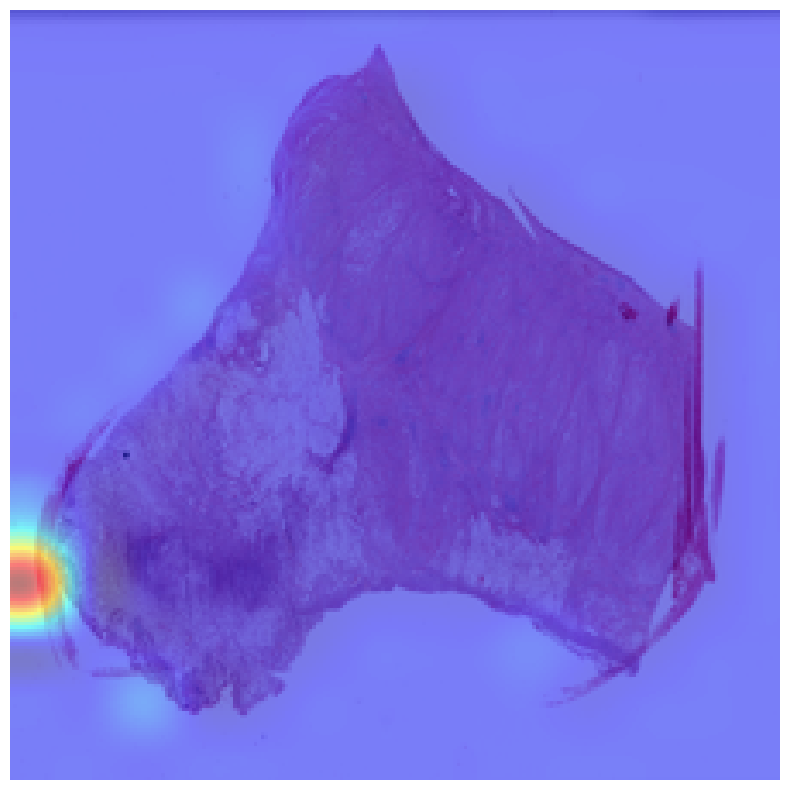

In [22]:
model.eval()
backbone.eval()

# Load the full WSI image
wsi_image_path = "/kaggle/input/tcga12/TCGA1.tif"
wsi_image = Image.open(wsi_image_path).convert("RGB")

transform_for_inference = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

img = transform_for_inference(wsi_image).unsqueeze(0).to(device)

# Get attention maps from the teacher backbone
# You may need to ensure your backbone supports extracting attentions. The DINO ViT models usually do.
attentions = backbone.get_last_selfattention(img)

# attentions shape is typically [batch, heads, tokens, tokens]
attn = attentions[0, :, 0, 1:]  # focus on the class token's attention to the image patches
nh = attn.shape[0]  # number of heads

# You might average the heads or just take one
attn = attn.mean(0)  # average over heads
attn = attn.reshape(14,14).detach().cpu().numpy()  # ViT-S/16 trained on 224x224 has 14x14 patches

# Rescale attention map to original image size
attn_resized = cv2.resize(attn, (224, 224), interpolation=cv2.INTER_CUBIC)
resized_wsi = wsi_image.resize((224, 224))
# Normalize to [0,1]
attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())

# Create a heatmap
heatmap = cv2.applyColorMap((attn_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = (np.array(resized_wsi) * 0.5 + heatmap * 0.5).astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.show()